# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 17

**Author 1 (sciper):** Ben Haj Yahia AHMED (261317)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

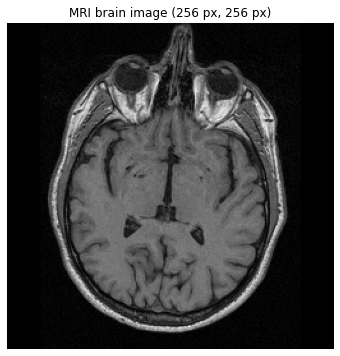

In [20]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im_path = os.path.join(data_path, 'brain-slice40.tiff')
brain_im = skimage.io.imread(brain_im_path)
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

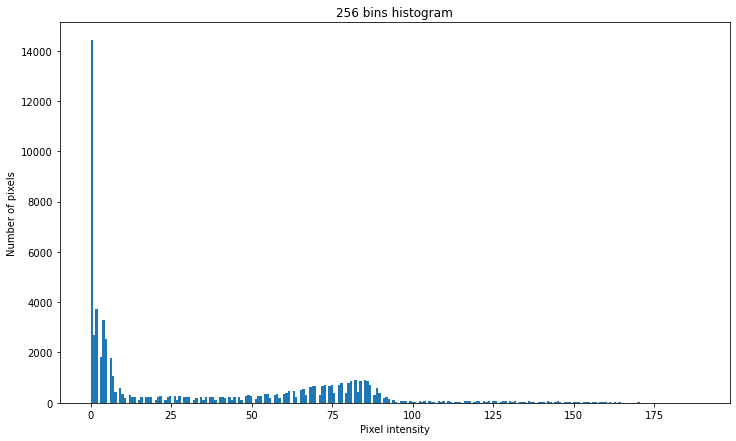

In [21]:
nb_bins = 256

# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(brain_im.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')

plt.show()

### 1.2 Region growing (5pts)

The Watershed from sklearn library has a function (skimage.morphology.watershed()) that implements a region-growing approach that fills “basins” in the image. We choose to use it here.

In [22]:
from __future__ import print_function
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import argparse
import imutils
import cv2

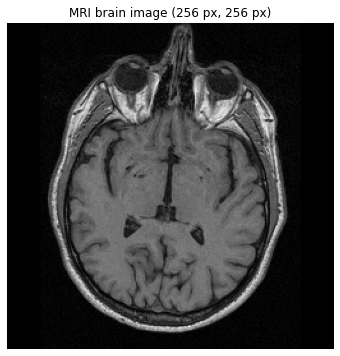

In [23]:
# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

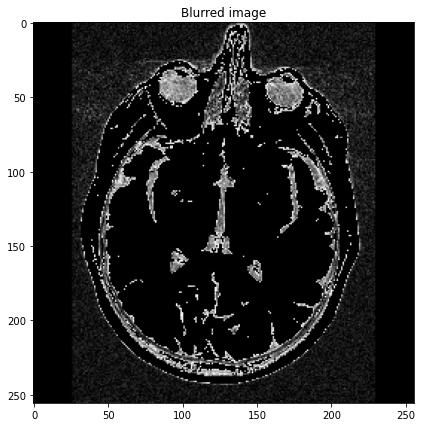

In [28]:
import skimage.filters
import numpy as np

brain_im_blur = skimage.filters.threshold_isodata(brain_im)
mask = brain_im<brain_im_blur
res = np.zeros_like(brain_im)
res[mask] = brain_im[mask]
plt.figure(figsize=(12, 7))
plt.imshow(res, cmap='gray')
plt.title('Blurred image')
plt.show()

### region growing method using watershed algorithm, but the implementation of the loop does not work.. It goes forever

In [29]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import argparse
import imutils
import cv2

thresh = cv2.threshold(brain_im, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,labels=thresh)
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

[INFO] 12 unique segments found


C:\Users\Bouhmid\Anaconda3\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


In [15]:
# loop over the unique labels returned by the Watershed

for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(brain_im.shape, dtype="uint8")
    mask[labels == label] = 255
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(brain_im, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(brain_im, "#{}".format(label), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    # show the output image
cv2.imshow("Output", brain_im)
cv2.waitKey(0)

KeyboardInterrupt: 

### 1.3 Contour detection (5pts)

# Add your implementation and discussion

--> I think we need to preprocess the Image before applying the canny edge but I coulnd't find the appropriate preprocessing steps

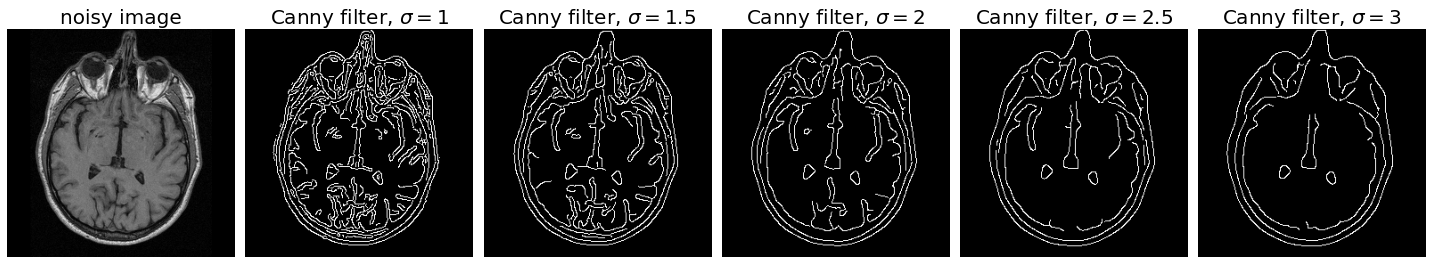

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Compute the Canny filter for two values of sigma
edges1 = feature.canny(brain_im)
edges2 = feature.canny(brain_im,sigma=1.5)
edges3 = feature.canny(brain_im,sigma=2)
edges4 = feature.canny(brain_im,sigma=2.5)
edges5 = feature.canny(brain_im, sigma=3)

# display results
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(20, 10),
                                    sharex=True, sharey=True)

ax1.imshow(brain_im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=1.5$', fontsize=20)

ax4.imshow(edges3, cmap=plt.cm.gray)
ax4.axis('off')
ax4.set_title(r'Canny filter, $\sigma=2$', fontsize=20)

ax5.imshow(edges4, cmap=plt.cm.gray)
ax5.axis('off')
ax5.set_title(r'Canny filter, $\sigma=2.5$', fontsize=20)

ax6.imshow(edges5, cmap=plt.cm.gray)
ax6.axis('off')
ax6.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

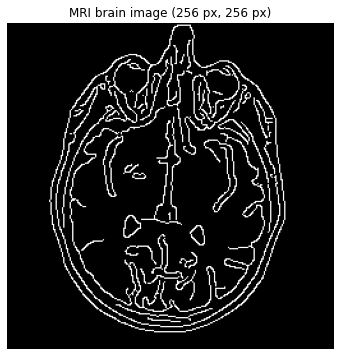

In [31]:
# Display best canny filter
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(edges2, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### finding appropriate preprocessing steps

In [32]:
import skimage as skimage
import skimage.viewer

C:\Users\Bouhmid\Anaconda3\lib\site-packages\skimage\viewer\utils\__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


In [34]:
def filter_function(image, sigma, threshold1, threshold2):
    masked = image.copy()
    masked[skimage.filters.gaussian(image, sigma=sigma) <= threshold1] = 0
    masked[skimage.filters.gaussian(image, sigma=sigma) >= threshold2] = 0

    return masked


smooth_threshold_plugin = skimage.viewer.plugins.Plugin(
    image_filter=filter_function
)

smooth_threshold_plugin.name = "Smooth and Threshold Plugin"

smooth_threshold_plugin += skimage.viewer.widgets.Slider(
    "sigma", low=0.0, high=7.0, value=1.0
)
smooth_threshold_plugin += skimage.viewer.widgets.Slider(
    "threshold1", low=0.0, high=1.0, value=0.5
)

smooth_threshold_plugin += skimage.viewer.widgets.Slider(
    "threshold2", low=0.0, high=1.0, value=0.5
)

image = brain_im.copy()

viewer = skimage.viewer.ImageViewer(image=image)
viewer += smooth_threshold_plugin
viewer.show()

[(array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), None)]

In [36]:
# [0.7 , 0.21, 0.33]

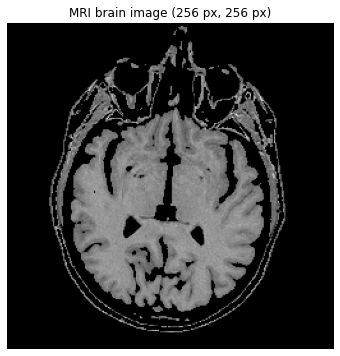

In [44]:
filtered = filter_function(brain_im,0.9,0.21,0.36)
# Display best canny filter
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(filtered, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.4 Additional method (5pts)

In [157]:
import skimage.filters as filters
import skimage.segmentation as seg


In [158]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [159]:
def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [150, 125], 80)[:-1]

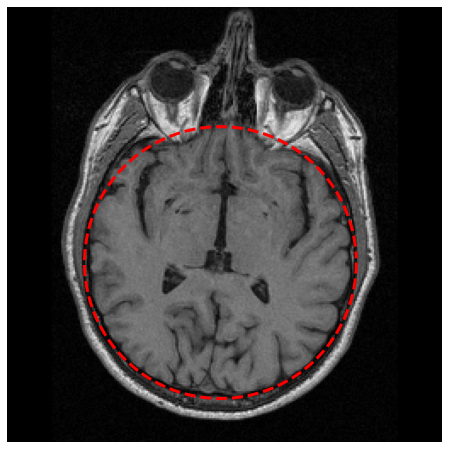

In [160]:
fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

C:\Users\Bouhmid\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  """Entry point for launching an IPython kernel.


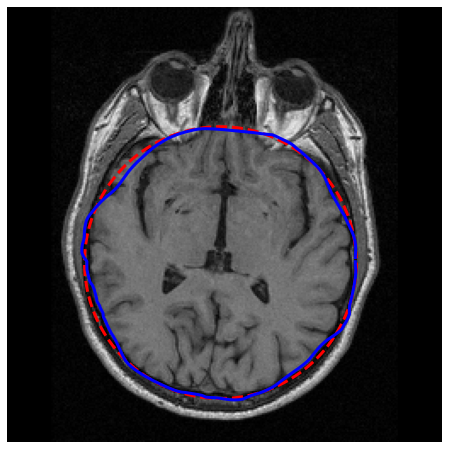

In [163]:
snake = seg.active_contour(brain_im, points, alpha=0.1,beta=0.2)
fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [ ]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [ ]:
# Add your implementation and discussion

### 2.3 Total area (in pixels) of each color (5 pts)

In [ ]:
# Add your implementation and discussion